<a href="https://colab.research.google.com/github/habhishek/CONV_VAE/blob/master/Convolutional_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Varational Autoencoder

## Imports

In [ ]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.layers as tfkl
import time

## Load the MNIST dataset

Each digit image is a vector of 978 integers, each of which is between 0-255 and represents a pixel. Size of the image is 28x28. We model each pixel with a Bernoulli distribution in our model and we statically binarize the dataset - keep each pixel value  either 0 or 1

In [ ]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# Binarize the dataset

def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > 0.5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [ ]:
train_size = 60000
batch_size = 32
test_size = 10000

## Use *tf.data* to batch and shuffle the data

Creates a dataset object using [`tf.data`](https://www.tensorflow.org/guide/data) and then apply underlying methods to shuffle and batch the data.

In [ ]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                  .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                  .shuffle(test_size).batch(batch_size))



## The Model

Implemented as tf.keras.Model subclass, the VAE model consists of 2 main parts - namely the encoder and decoder. These encoder and decoder networks a small ConvNets. In the literature these are reffered to as inference/recongnition and generative models respectively.

Its important to note the output layers of each of these ConvNets:-



*   **Encoder Output Layer** - `tf.keras.layers.Dense` that outputs concatenated means and standard deviations
*   **Decoder Output Layer** - `tf.layers.Conv2DTranpose` that outputs the logits of the reconstructed image produced by the decoder.



In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
         tfkl.InputLayer(input_shape=(28,28,1)),
         tfkl.Conv2D(
             filters=32, kernel_size=3, strides=(2,2), activation='relu'),
         tfkl.Conv2D(
             filters=64, kernel_size=3, strides=(2,2), activation='relu'),
         tfkl.Flatten(),
         # 2 times the latent dim because we concatenate the means and raw std
         # no activation
         tfkl.Dense(2*latent_dim)
        ]
    )
    self.decoder = tf.keras.Sequential(
        [
         tfkl.InputLayer(input_shape=(latent_dim,)),
         # Expand the dimensions using Dense layer and prepare for de-convolution
         tfkl.Dense(7*7*32, activation='relu'),
         # Reshape the flattened representation into a 3D, so that de-convolution
         # can be successfully applied
         tfkl.Reshape(target_shape=(7,7,32)),
         tfkl.Conv2DTranspose(
             filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
         tfkl.Conv2DTranspose(
             filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
         # note that no activation is required in the final layer as we will
         # take care of that in the loss function.
         tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')
        ]
    )
  
  def decode(self, z, apply_sigmoid=False):
    """Decoder network. Takes the sample z from latent space, runs through
     the decoder to output the reconstructed image or logits. If not using
     sigmoid_cross_entropy loss, keep apply_sigmoid=True to output sigmoid
     logits"""
    x_logits = self.decoder(z)
    if apply_sigmoid:
      x_logits_with_sigmoid = tf.sigmoid(x_logits)
      return x_logits_with_sigmoid
    else:
      return x_logits
  
  def encode(self, x):
    """Use Inference model to represent x into latent z mean and logvar"""
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    """Apply Reparameterization Trick to the encoder output means and logvar"""
    eps = tf.random.normal(shape=mean.shape) #random noise epsilon
    return eps * tf.exp(logvar * .5) + mean

  @tf.function
  def sample(self, eps=None):
    """Generation, after training - Sample from Gaussian Prior and use decoder
        to generate"""
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)
    

## The Loss Function
The goal of our generative model is to essentially maximize the log probability of the datapoint x or $\log p(x)$. Using the variational principal and inference techniques we define the VAE model loss function as that equal to maximizing the Evidence Lower Bound (ELBO) on the marginal log-likelihood.

In other words, the marginal log-likehood of the data defined as:-

$\log p(x) = \log\int{p(x,z)}dz$

is intractable. The encoder-decoder combination is essentially a method of applying the variational technique to find this intractable $\log p(x)$. During this application, since we cannot directly compute the posterior probability of the latent space $p(z|x)$, for similar reasons as stated above, we try to approximate this density function using another probability density function $q(z|x)$. This introduction of an aproximate posterior then converts the problem into an optimization problem. Instead of trying to maximize our log probability of the data, we try to improve our approximation of the posterior. We decrease the measure of farness (or divergence) of the aproximate posterior and the true posterior.

This application helps us to define an ELBO over the marginal log likelihood as defined below:-
\begin{equation}\label{eblo_1}
ELBO = \mathbb{E}_{z\sim{q(z|x)}}[\log{p(x|z)}]- D_{KL}((q|z)||p(z))
\end{equation}

Can also be defined in terms of $\mathbb{E}_{z\sim{q(z|x)}}$ as below:-

\begin{equation}\label{elbo_2}
ELBO = \mathbb{E}_{z\sim{q(z|x)}}[\log{p(x|z)}- \log{(q|z)} + \log{p(z))}]
\end{equation}

Using the Monte Carlo Sampling technique, for simplicity we can define this for a single sample:-

\begin{equation}\label{elbo_3}
ELBO = \log{p(x|z)}- \log{(q|z)} + \log{p(z))}
\end{equation}

We try to maximum the ELBO or minimize the -ELBO.

The first part of this ELBO is called the Reconstruction term and the second term is called the Regularizer.

1. **Reconstruction Loss**:- $\log{p(x|z)}$ essentially measures the quality of reconstructed image from the decoder. Is implemented here using the `tf.nn.sigmoid_cross_entropy_with_logits`. Reconstruction loss also read as negative log likelihood of the data or probability of x, given the latent sample z. We take the sigmoid cross entropy loss of each pixel values of the input x and reconstructed image of the logits from the decoder. We then take sum of all these values(using `tf.math.reduce_sum`) and the sum thereby represents the log likelihood of the data.

2. **Regularizer**:- KL Divergence term is also known as the Regularizer. Since we cannot directly measure the quality of approximation, i.e., $q(z|x)$, we try to instead keep it closer to a known, simple (and tractable) prior distribution $p(x)$- in this case a Gaussian. This KL term helps in acheiving this objective and is a part of the ELBO. The generic implementation for a single Monte Carlo sampling has the terms - $\log{p(z))}-\log{(q|z)}$. The Analytical KL divergence can also be computed for a special case where we assume that the true $p(z)$ has a diagonal covariance matrix.

We define a function to calculate the neccessary log normal pdfs in the loss function

In [ ]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

In [ ]:
def compute_loss(model, x, analytical_kl = False):
  '''Compute the VAE loss defined on the EBLO
     If analytica_kl = True, compute the analytical KL divergence
     instead of the Monte Carlo approximation'''
  mean, logvar = model.encode(x)
  z_sample = model.reparameterize(mean, logvar)
  x_recon_logits = model.decode(z_sample)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(
              labels=x,logits=x_recon_logits) # shape=(batch_size, 28, 28, 1)
  # For reconstruction loss over the mini batch,
  # sum over the cross_entropy loss of each pixel
  logpx_z = -tf.math.reduce_sum(cross_ent, axis=[1, 2, 3]) # shape=(batch_size,1)
  
  # Now compute reverse KL divergence, either analytically 
  # or through MC approximation with one sample
  if analytical_kl:
    kl_divergence = - 0.5 * tf.math.reduce_sum(
            logvar - tf.square(mean) - tf.exp(logvar) + 1,
            axis=1)  # shape=(batch_size, )
  else:
    logpz = log_normal_pdf(z_sample, 0., 0.)
    logqz_x = log_normal_pdf(z_sample, mean, logvar)
    kl_divergence = logqz_x - logpz
  
  elbo = tf.reduce_mean(logpx_z - kl_divergence)
  return -elbo


In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(model, x, optimizer):
  '''Execute one train step using
     Calculate the loss and gradients using the model loss function.
     Apply back the gradients to the model'''
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))


## Training and Generation

In [ ]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [ ]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

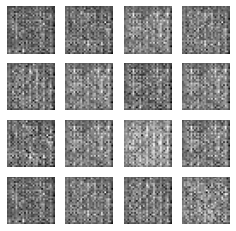

In [ ]:
generate_and_save_images(model, 0, test_sample)

Epoch: 1, Test set ELBO: -178.48582458496094, time elapse for current epoch: 5.005463123321533


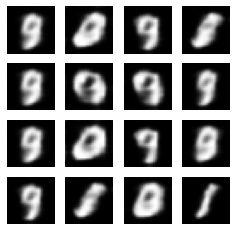

Epoch: 2, Test set ELBO: -170.67933654785156, time elapse for current epoch: 4.075359106063843


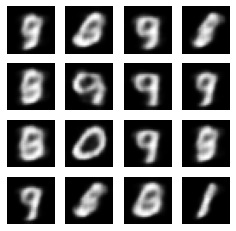

Epoch: 3, Test set ELBO: -166.13291931152344, time elapse for current epoch: 4.06704306602478


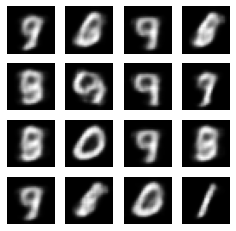

Epoch: 4, Test set ELBO: -163.37103271484375, time elapse for current epoch: 4.029253959655762


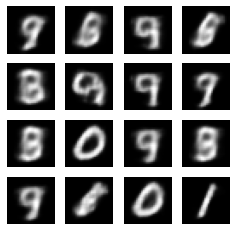

Epoch: 5, Test set ELBO: -161.25880432128906, time elapse for current epoch: 4.060126543045044


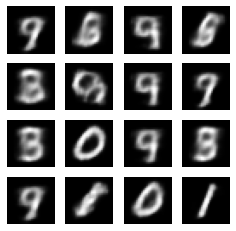

Epoch: 6, Test set ELBO: -159.6279296875, time elapse for current epoch: 4.046212434768677


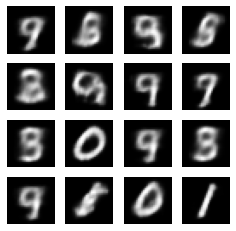

Epoch: 7, Test set ELBO: -158.53367614746094, time elapse for current epoch: 4.053965330123901


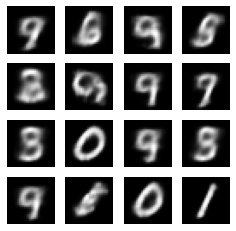

Epoch: 8, Test set ELBO: -158.1690216064453, time elapse for current epoch: 4.094677925109863


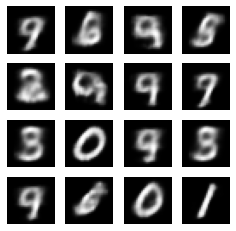

Epoch: 9, Test set ELBO: -157.82469177246094, time elapse for current epoch: 4.081508159637451


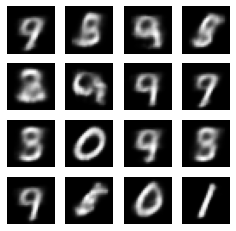

Epoch: 10, Test set ELBO: -156.57603454589844, time elapse for current epoch: 4.085996866226196


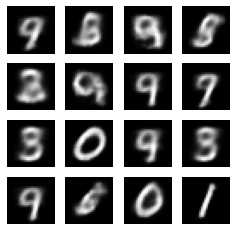

In [ ]:
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  #display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

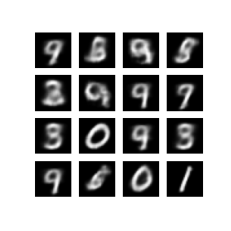

In [ ]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images